# Import Libraries

In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise. 


In [3]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                      #  transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [4]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


# Dataloader Arguments & Test/Train Dataloaders


In [5]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [6]:
class GhostBatchNorm(nn.BatchNorm2d):
    """
    From : https://github.com/davidcpage/cifar10-fast/blob/master/bag_of_tricks.ipynb

    Batch norm seems to work best with batch size of around 32. The reasons presumably have to do 
    with noise in the batch statistics and specifically a balance between a beneficial regularising effect 
    at intermediate batch sizes and an excess of noise at small batches.
    
    Our batches are of size 512 and we can't afford to reduce them without taking a serious hit on training times, 
    but we can apply batch norm separately to subsets of a training batch. This technique, known as 'ghost' batch 
    norm, is usually used in a distributed setting but is just as useful when using large batches on a single node. 
    It isn't supported directly in PyTorch but we can roll our own easily enough.
    """
    def __init__(self, num_features, num_splits, eps=1e-05, momentum=0.1, weight=True, bias=True):
        super(GhostBatchNorm, self).__init__(num_features, eps=eps, momentum=momentum)
        self.weight.data.fill_(1.0)
        self.bias.data.fill_(0.0)
        self.weight.requires_grad = weight
        self.bias.requires_grad = bias        
        self.num_splits = num_splits
        self.register_buffer('running_mean', torch.zeros(num_features*self.num_splits))
        self.register_buffer('running_var', torch.ones(num_features*self.num_splits))

    def train(self, mode=True):
        if (self.training is True) and (mode is False):
            self.running_mean = torch.mean(self.running_mean.view(self.num_splits, self.num_features), dim=0).repeat(self.num_splits)
            self.running_var = torch.mean(self.running_var.view(self.num_splits, self.num_features), dim=0).repeat(self.num_splits)
        return super(GhostBatchNorm, self).train(mode)
        
    def forward(self, input):
        N, C, H, W = input.shape
        if self.training or not self.track_running_stats:
            return F.batch_norm(
                input.view(-1, C*self.num_splits, H, W), self.running_mean, self.running_var, 
                self.weight.repeat(self.num_splits), self.bias.repeat(self.num_splits),
                True, self.momentum, self.eps).view(N, C, H, W) 
        else:
            return F.batch_norm(
                input, self.running_mean[:self.num_features], self.running_var[:self.num_features], 
                self.weight, self.bias, False, self.momentum, self.eps)

# The model
Let's start with the model we first saw

In [7]:
dropout_value=0.05
class Net(nn.Module):
    def __init__(self, Ghost_BN = False):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16) if Ghost_BN is False else GhostBatchNorm(num_features=16,num_splits=4, weight=False),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16) if Ghost_BN is False else GhostBatchNorm(num_features=16,num_splits=4, weight=False),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.ReLU(),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16) if Ghost_BN is False else GhostBatchNorm(num_features=16,num_splits=4, weight=False),
            nn.Dropout(dropout_value)
        ) # output_size = 10

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16) if Ghost_BN is False else GhostBatchNorm(num_features=16,num_splits=4, weight=False),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10) if Ghost_BN is False else GhostBatchNorm(num_features=10,num_splits=4, weight=False),
            nn.Dropout(dropout_value)
        ) # output_size = 6

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(10) if Ghost_BN is False else GhostBatchNorm(num_features=10,num_splits=4, weight=False),
            nn.Dropout(dropout_value)
        ) # output_size = 6

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        )
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10), NEVER
            # nn.ReLU() NEVER!
        ) # output_size = 1

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.gap(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is. 
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [8]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,304
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 16, 24, 24]             256
             ReLU-10           [-1, 16, 24, 24]               0
        MaxPool2d-11           [-1, 16, 12, 12]               0
           Conv2d-12           [-1, 16, 10, 10]           2,304
             ReLU-13           [-1, 16, 10, 10]               0
      BatchNorm2d-14           [-1

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs. 

Let's write train and test functions

In [9]:
from tqdm import tqdm

def train(model, device, train_loader, optimizer, epoch, l1_penalty = 0):
    train_losses = []
    train_accuracy = []

    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
      # get samples
      data, target = data.to(device), target.to(device)

      # Init
      optimizer.zero_grad()
      # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
      # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

      # Predict
      y_pred = model(data)

      # Calculate loss
      loss = F.nll_loss(y_pred, target)
          # l1 regularization
      if l1_penalty:
          with torch.enable_grad():
              l1_loss=0
              for param in model.parameters():
                  l1_loss+=torch.sum(param.abs())
              loss+=l1_penalty*l1_loss  

      train_losses.append(loss)
      
      # Backpropagation
      loss.backward()
      optimizer.step()

      # Update pbar-tqdm
      
      pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
      correct += pred.eq(target.view_as(pred)).sum().item()
      processed += len(data)
      
      pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy: {100*correct/processed:0.2f}% ')
      train_accuracy.append(100*correct/processed)
 
    return train_losses, train_accuracy

def test(model, device, test_loader):
    test_losses = []
    test_accuracy = []

    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_accuracy.append(100. * correct / len(test_loader.dataset))
    return test_losses, test_accuracy


# Let's Train and test our model

In [10]:
model_versions = {1:"L1 + BN", 2:"L2 + BN", 3:"L1 + L2 + BN", 4:"GBN", 5:"L1 + GBN", 6:"L2 + GBN", 7:"L1 + L2 + GBN"}

In [11]:
print(model_versions[1])
print(model_versions[2])
print(model_versions[3])
print(model_versions[4])
print(model_versions[5])
print(model_versions[6])
print(model_versions[7])

L1 + BN
L2 + BN
L1 + L2 + BN
GBN
L1 + GBN
L2 + GBN
L1 + L2 + GBN


In [12]:
def get_regularization_params(model_version):
  if "GBN" in model_version:
    Ghost_BN = True
  else:
    Ghost_BN = False

  if "L1" in model_version:
    l1_penalty = 0.0001
  else:
    l1_penalty = 0

  if "L2" in model_version:
    l2_penalty = 1e-5
  else:
    l2_penalty = 0
  
  return l1_penalty, l2_penalty, Ghost_BN

In [13]:
EPOCHS = 25
model_history = {}
for model_number, model_version in model_versions.items():
  print(model_version)

  train_loss=[]
  train_acc=[]
  test_loss=[]
  test_acc=[]

  l1_penalty, l2_penalty, Ghost_BN = get_regularization_params(model_version)
  print(f"l1_penalty: {l1_penalty}"); print(f"l2_penalty: {l2_penalty}"); print(f"Ghost_BN: {Ghost_BN}")
  
  model = Net(Ghost_BN).to(device)
  optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=l2_penalty)
  
  for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train_loss_epoch, train_accuracy_epoch = train(model, device, train_loader, optimizer, epoch,l1_penalty)
    train_loss.append(train_loss_epoch)
    train_acc.append(train_accuracy_epoch)
    test_loss_epoch, test_accuracy_epoch = test(model, device, test_loader)
    test_loss.append(test_loss_epoch)
    test_acc.append(test_accuracy_epoch)

  model_history[model_number]={"train_loss":train_loss, "train_acc":train_acc, "test_loss":test_loss, "test_acc":test_acc}

# print(f"\nMaximum training accuracy: {train_max}\n")
# print(f"\nMaximum test accuracy: {test_max}\n")

  0%|          | 0/469 [00:00<?, ?it/s]

L1 + BN
l1_penalty: 0.0001
l2_penalty: 0
Ghost_BN: False
EPOCH: 0


Loss=0.17239058017730713 Batch_id=468 Accuracy: 86.17% : 100%|██████████| 469/469 [00:14<00:00, 33.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0715, Accuracy: 9823/10000 (98.23%)

EPOCH: 1


Loss=0.10067039728164673 Batch_id=468 Accuracy: 97.94% : 100%|██████████| 469/469 [00:14<00:00, 33.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0461, Accuracy: 9876/10000 (98.76%)

EPOCH: 2


Loss=0.13861295580863953 Batch_id=468 Accuracy: 98.39% : 100%|██████████| 469/469 [00:13<00:00, 33.65it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0448, Accuracy: 9857/10000 (98.57%)

EPOCH: 3


Loss=0.0751916840672493 Batch_id=468 Accuracy: 98.60% : 100%|██████████| 469/469 [00:14<00:00, 32.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0373, Accuracy: 9895/10000 (98.95%)

EPOCH: 4


Loss=0.1093558743596077 Batch_id=468 Accuracy: 98.66% : 100%|██████████| 469/469 [00:14<00:00, 33.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0346, Accuracy: 9905/10000 (99.05%)

EPOCH: 5


Loss=0.06793477386236191 Batch_id=468 Accuracy: 98.79% : 100%|██████████| 469/469 [00:14<00:00, 33.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0271, Accuracy: 9917/10000 (99.17%)

EPOCH: 6


Loss=0.09780537337064743 Batch_id=468 Accuracy: 98.83% : 100%|██████████| 469/469 [00:14<00:00, 32.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9901/10000 (99.01%)

EPOCH: 7


Loss=0.07958465814590454 Batch_id=468 Accuracy: 98.89% : 100%|██████████| 469/469 [00:13<00:00, 33.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0324, Accuracy: 9903/10000 (99.03%)

EPOCH: 8


Loss=0.08502668142318726 Batch_id=468 Accuracy: 98.93% : 100%|██████████| 469/469 [00:14<00:00, 33.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Accuracy: 9918/10000 (99.18%)

EPOCH: 9


Loss=0.11555086076259613 Batch_id=468 Accuracy: 98.96% : 100%|██████████| 469/469 [00:14<00:00, 32.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9927/10000 (99.27%)

EPOCH: 10


Loss=0.08355538547039032 Batch_id=468 Accuracy: 98.91% : 100%|██████████| 469/469 [00:14<00:00, 32.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0303, Accuracy: 9906/10000 (99.06%)

EPOCH: 11


Loss=0.08398699760437012 Batch_id=468 Accuracy: 99.04% : 100%|██████████| 469/469 [00:14<00:00, 31.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0338, Accuracy: 9897/10000 (98.97%)

EPOCH: 12


Loss=0.08361548185348511 Batch_id=468 Accuracy: 98.95% : 100%|██████████| 469/469 [00:14<00:00, 31.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0305, Accuracy: 9902/10000 (99.02%)

EPOCH: 13


Loss=0.11161263287067413 Batch_id=468 Accuracy: 99.04% : 100%|██████████| 469/469 [00:14<00:00, 32.56it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0401, Accuracy: 9885/10000 (98.85%)

EPOCH: 14


Loss=0.09834177792072296 Batch_id=468 Accuracy: 98.95% : 100%|██████████| 469/469 [00:14<00:00, 32.93it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0326, Accuracy: 9905/10000 (99.05%)

EPOCH: 15


Loss=0.09314295649528503 Batch_id=468 Accuracy: 99.11% : 100%|██████████| 469/469 [00:14<00:00, 33.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9928/10000 (99.28%)

EPOCH: 16


Loss=0.0587947852909565 Batch_id=468 Accuracy: 99.12% : 100%|██████████| 469/469 [00:14<00:00, 32.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9920/10000 (99.20%)

EPOCH: 17


Loss=0.07889000326395035 Batch_id=468 Accuracy: 99.08% : 100%|██████████| 469/469 [00:14<00:00, 32.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0322, Accuracy: 9899/10000 (98.99%)

EPOCH: 18


Loss=0.07825394719839096 Batch_id=468 Accuracy: 99.15% : 100%|██████████| 469/469 [00:14<00:00, 32.85it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0382, Accuracy: 9883/10000 (98.83%)

EPOCH: 19


Loss=0.1322801411151886 Batch_id=468 Accuracy: 99.15% : 100%|██████████| 469/469 [00:14<00:00, 33.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0288, Accuracy: 9902/10000 (99.02%)

EPOCH: 20


Loss=0.05529937520623207 Batch_id=468 Accuracy: 99.18% : 100%|██████████| 469/469 [00:14<00:00, 32.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9934/10000 (99.34%)

EPOCH: 21


Loss=0.06431622058153152 Batch_id=468 Accuracy: 99.14% : 100%|██████████| 469/469 [00:14<00:00, 33.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0251, Accuracy: 9927/10000 (99.27%)

EPOCH: 22


Loss=0.05987967550754547 Batch_id=468 Accuracy: 99.14% : 100%|██████████| 469/469 [00:14<00:00, 33.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0357, Accuracy: 9891/10000 (98.91%)

EPOCH: 23


Loss=0.09237945824861526 Batch_id=468 Accuracy: 99.11% : 100%|██████████| 469/469 [00:14<00:00, 32.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9921/10000 (99.21%)

EPOCH: 24


Loss=0.09931051731109619 Batch_id=468 Accuracy: 99.20% : 100%|██████████| 469/469 [00:14<00:00, 33.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9917/10000 (99.17%)

L2 + BN
l1_penalty: 0
l2_penalty: 1e-05
Ghost_BN: False
EPOCH: 0


Loss=0.07649501413106918 Batch_id=468 Accuracy: 87.38% : 100%|██████████| 469/469 [00:13<00:00, 36.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1272, Accuracy: 9657/10000 (96.57%)

EPOCH: 1


Loss=0.12257937341928482 Batch_id=468 Accuracy: 97.46% : 100%|██████████| 469/469 [00:13<00:00, 35.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0496, Accuracy: 9854/10000 (98.54%)

EPOCH: 2


Loss=0.08992975205183029 Batch_id=468 Accuracy: 98.19% : 100%|██████████| 469/469 [00:13<00:00, 35.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0339, Accuracy: 9909/10000 (99.09%)

EPOCH: 3


Loss=0.028036823496222496 Batch_id=468 Accuracy: 98.52% : 100%|██████████| 469/469 [00:13<00:00, 35.35it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0395, Accuracy: 9871/10000 (98.71%)

EPOCH: 4


Loss=0.056638266891241074 Batch_id=468 Accuracy: 98.68% : 100%|██████████| 469/469 [00:13<00:00, 35.51it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9921/10000 (99.21%)

EPOCH: 5


Loss=0.024773893877863884 Batch_id=468 Accuracy: 98.82% : 100%|██████████| 469/469 [00:13<00:00, 35.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Accuracy: 9913/10000 (99.13%)

EPOCH: 6


Loss=0.030773242935538292 Batch_id=468 Accuracy: 98.98% : 100%|██████████| 469/469 [00:12<00:00, 36.15it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9914/10000 (99.14%)

EPOCH: 7


Loss=0.027359269559383392 Batch_id=468 Accuracy: 99.00% : 100%|██████████| 469/469 [00:13<00:00, 35.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0235, Accuracy: 9927/10000 (99.27%)

EPOCH: 8


Loss=0.06379489600658417 Batch_id=468 Accuracy: 99.09% : 100%|██████████| 469/469 [00:13<00:00, 35.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9912/10000 (99.12%)

EPOCH: 9


Loss=0.0045561473816633224 Batch_id=468 Accuracy: 99.11% : 100%|██████████| 469/469 [00:13<00:00, 35.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9932/10000 (99.32%)

EPOCH: 10


Loss=0.008839433081448078 Batch_id=468 Accuracy: 99.14% : 100%|██████████| 469/469 [00:12<00:00, 36.29it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9929/10000 (99.29%)

EPOCH: 11


Loss=0.005085924174636602 Batch_id=468 Accuracy: 99.16% : 100%|██████████| 469/469 [00:13<00:00, 35.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9929/10000 (99.29%)

EPOCH: 12


Loss=0.02192126400768757 Batch_id=468 Accuracy: 99.24% : 100%|██████████| 469/469 [00:13<00:00, 35.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0217, Accuracy: 9937/10000 (99.37%)

EPOCH: 13


Loss=0.03218794986605644 Batch_id=468 Accuracy: 99.27% : 100%|██████████| 469/469 [00:12<00:00, 36.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0202, Accuracy: 9939/10000 (99.39%)

EPOCH: 14


Loss=0.010908161289989948 Batch_id=468 Accuracy: 99.21% : 100%|██████████| 469/469 [00:13<00:00, 35.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0184, Accuracy: 9944/10000 (99.44%)

EPOCH: 15


Loss=0.11406081169843674 Batch_id=468 Accuracy: 99.31% : 100%|██████████| 469/469 [00:13<00:00, 35.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9931/10000 (99.31%)

EPOCH: 16


Loss=0.010988597758114338 Batch_id=468 Accuracy: 99.33% : 100%|██████████| 469/469 [00:13<00:00, 35.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9941/10000 (99.41%)

EPOCH: 17


Loss=0.010651732794940472 Batch_id=468 Accuracy: 99.34% : 100%|██████████| 469/469 [00:12<00:00, 36.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9925/10000 (99.25%)

EPOCH: 18


Loss=0.03736317530274391 Batch_id=468 Accuracy: 99.38% : 100%|██████████| 469/469 [00:13<00:00, 35.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0203, Accuracy: 9940/10000 (99.40%)

EPOCH: 19


Loss=0.004781264346092939 Batch_id=468 Accuracy: 99.41% : 100%|██████████| 469/469 [00:13<00:00, 35.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0200, Accuracy: 9941/10000 (99.41%)

EPOCH: 20


Loss=0.00948785524815321 Batch_id=468 Accuracy: 99.43% : 100%|██████████| 469/469 [00:13<00:00, 35.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9931/10000 (99.31%)

EPOCH: 21


Loss=0.0014088833704590797 Batch_id=468 Accuracy: 99.36% : 100%|██████████| 469/469 [00:13<00:00, 35.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0177, Accuracy: 9943/10000 (99.43%)

EPOCH: 22


Loss=0.048906225711107254 Batch_id=468 Accuracy: 99.44% : 100%|██████████| 469/469 [00:13<00:00, 35.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0201, Accuracy: 9938/10000 (99.38%)

EPOCH: 23


Loss=0.03414437547326088 Batch_id=468 Accuracy: 99.40% : 100%|██████████| 469/469 [00:13<00:00, 35.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0192, Accuracy: 9939/10000 (99.39%)

EPOCH: 24


Loss=0.056120291352272034 Batch_id=468 Accuracy: 99.47% : 100%|██████████| 469/469 [00:13<00:00, 35.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0205, Accuracy: 9939/10000 (99.39%)

L1 + L2 + BN
l1_penalty: 0.0001
l2_penalty: 1e-05
Ghost_BN: False
EPOCH: 0


Loss=0.16370823979377747 Batch_id=468 Accuracy: 87.69% : 100%|██████████| 469/469 [00:14<00:00, 32.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0913, Accuracy: 9761/10000 (97.61%)

EPOCH: 1


Loss=0.11450840532779694 Batch_id=468 Accuracy: 97.61% : 100%|██████████| 469/469 [00:14<00:00, 33.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0490, Accuracy: 9869/10000 (98.69%)

EPOCH: 2


Loss=0.11586375534534454 Batch_id=468 Accuracy: 98.22% : 100%|██████████| 469/469 [00:14<00:00, 32.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0406, Accuracy: 9884/10000 (98.84%)

EPOCH: 3


Loss=0.18717658519744873 Batch_id=468 Accuracy: 98.47% : 100%|██████████| 469/469 [00:14<00:00, 32.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0310, Accuracy: 9917/10000 (99.17%)

EPOCH: 4


Loss=0.09664280712604523 Batch_id=468 Accuracy: 98.70% : 100%|██████████| 469/469 [00:14<00:00, 33.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0324, Accuracy: 9908/10000 (99.08%)

EPOCH: 5


Loss=0.09789033234119415 Batch_id=468 Accuracy: 98.77% : 100%|██████████| 469/469 [00:14<00:00, 32.72it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0332, Accuracy: 9905/10000 (99.05%)

EPOCH: 6


Loss=0.07365354895591736 Batch_id=468 Accuracy: 98.75% : 100%|██████████| 469/469 [00:14<00:00, 33.30it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0273, Accuracy: 9918/10000 (99.18%)

EPOCH: 7


Loss=0.07563326507806778 Batch_id=468 Accuracy: 98.89% : 100%|██████████| 469/469 [00:14<00:00, 32.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0309, Accuracy: 9902/10000 (99.02%)

EPOCH: 8


Loss=0.09063930809497833 Batch_id=468 Accuracy: 98.94% : 100%|██████████| 469/469 [00:14<00:00, 32.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0286, Accuracy: 9913/10000 (99.13%)

EPOCH: 9


Loss=0.1149236187338829 Batch_id=468 Accuracy: 98.95% : 100%|██████████| 469/469 [00:14<00:00, 32.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9914/10000 (99.14%)

EPOCH: 10


Loss=0.1115407943725586 Batch_id=468 Accuracy: 98.94% : 100%|██████████| 469/469 [00:14<00:00, 32.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0296, Accuracy: 9911/10000 (99.11%)

EPOCH: 11


Loss=0.06897831708192825 Batch_id=468 Accuracy: 98.96% : 100%|██████████| 469/469 [00:14<00:00, 32.98it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0256, Accuracy: 9917/10000 (99.17%)

EPOCH: 12


Loss=0.1123984158039093 Batch_id=468 Accuracy: 99.08% : 100%|██████████| 469/469 [00:14<00:00, 32.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9926/10000 (99.26%)

EPOCH: 13


Loss=0.09088107198476791 Batch_id=468 Accuracy: 99.02% : 100%|██████████| 469/469 [00:14<00:00, 32.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9906/10000 (99.06%)

EPOCH: 14


Loss=0.08677686750888824 Batch_id=468 Accuracy: 99.08% : 100%|██████████| 469/469 [00:14<00:00, 32.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9909/10000 (99.09%)

EPOCH: 15


Loss=0.11095108091831207 Batch_id=468 Accuracy: 99.00% : 100%|██████████| 469/469 [00:14<00:00, 32.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0261, Accuracy: 9918/10000 (99.18%)

EPOCH: 16


Loss=0.09003934264183044 Batch_id=468 Accuracy: 99.08% : 100%|██████████| 469/469 [00:14<00:00, 33.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Accuracy: 9908/10000 (99.08%)

EPOCH: 17


Loss=0.09690780192613602 Batch_id=468 Accuracy: 99.11% : 100%|██████████| 469/469 [00:14<00:00, 33.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0337, Accuracy: 9897/10000 (98.97%)

EPOCH: 18


Loss=0.10938799381256104 Batch_id=468 Accuracy: 99.11% : 100%|██████████| 469/469 [00:14<00:00, 33.22it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0282, Accuracy: 9912/10000 (99.12%)

EPOCH: 19


Loss=0.05954622104763985 Batch_id=468 Accuracy: 99.14% : 100%|██████████| 469/469 [00:14<00:00, 32.90it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9915/10000 (99.15%)

EPOCH: 20


Loss=0.0737321600317955 Batch_id=468 Accuracy: 99.16% : 100%|██████████| 469/469 [00:14<00:00, 32.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0270, Accuracy: 9921/10000 (99.21%)

EPOCH: 21


Loss=0.07624509185552597 Batch_id=468 Accuracy: 99.03% : 100%|██████████| 469/469 [00:14<00:00, 33.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0351, Accuracy: 9890/10000 (98.90%)

EPOCH: 22


Loss=0.06616868078708649 Batch_id=468 Accuracy: 99.16% : 100%|██████████| 469/469 [00:14<00:00, 32.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9918/10000 (99.18%)

EPOCH: 23


Loss=0.10792236775159836 Batch_id=468 Accuracy: 99.23% : 100%|██████████| 469/469 [00:14<00:00, 33.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0245, Accuracy: 9921/10000 (99.21%)

EPOCH: 24


Loss=0.09110873937606812 Batch_id=468 Accuracy: 99.17% : 100%|██████████| 469/469 [00:14<00:00, 33.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9930/10000 (99.30%)

GBN
l1_penalty: 0
l2_penalty: 0
Ghost_BN: True
EPOCH: 0


Loss=0.2217678278684616 Batch_id=468 Accuracy: 84.92% : 100%|██████████| 469/469 [00:13<00:00, 35.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1862, Accuracy: 9696/10000 (96.96%)

EPOCH: 1


Loss=0.18079735338687897 Batch_id=468 Accuracy: 97.06% : 100%|██████████| 469/469 [00:13<00:00, 35.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0695, Accuracy: 9855/10000 (98.55%)

EPOCH: 2


Loss=0.08174284547567368 Batch_id=468 Accuracy: 97.79% : 100%|██████████| 469/469 [00:13<00:00, 35.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0605, Accuracy: 9871/10000 (98.71%)

EPOCH: 3


Loss=0.10250537842512131 Batch_id=468 Accuracy: 98.12% : 100%|██████████| 469/469 [00:13<00:00, 35.84it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0438, Accuracy: 9900/10000 (99.00%)

EPOCH: 4


Loss=0.0861130952835083 Batch_id=468 Accuracy: 98.25% : 100%|██████████| 469/469 [00:13<00:00, 35.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0408, Accuracy: 9888/10000 (98.88%)

EPOCH: 5


Loss=0.10756012797355652 Batch_id=468 Accuracy: 98.42% : 100%|██████████| 469/469 [00:13<00:00, 35.37it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0417, Accuracy: 9890/10000 (98.90%)

EPOCH: 6


Loss=0.014793000183999538 Batch_id=468 Accuracy: 98.51% : 100%|██████████| 469/469 [00:13<00:00, 35.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0337, Accuracy: 9916/10000 (99.16%)

EPOCH: 7


Loss=0.12575596570968628 Batch_id=468 Accuracy: 98.61% : 100%|██████████| 469/469 [00:13<00:00, 35.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0357, Accuracy: 9900/10000 (99.00%)

EPOCH: 8


Loss=0.026790739968419075 Batch_id=468 Accuracy: 98.62% : 100%|██████████| 469/469 [00:13<00:00, 35.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0301, Accuracy: 9919/10000 (99.19%)

EPOCH: 9


Loss=0.044689685106277466 Batch_id=468 Accuracy: 98.80% : 100%|██████████| 469/469 [00:13<00:00, 35.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0306, Accuracy: 9916/10000 (99.16%)

EPOCH: 10


Loss=0.02654419094324112 Batch_id=468 Accuracy: 98.81% : 100%|██████████| 469/469 [00:13<00:00, 35.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Accuracy: 9917/10000 (99.17%)

EPOCH: 11


Loss=0.05127474293112755 Batch_id=468 Accuracy: 98.81% : 100%|██████████| 469/469 [00:12<00:00, 36.19it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0295, Accuracy: 9921/10000 (99.21%)

EPOCH: 12


Loss=0.04256567358970642 Batch_id=468 Accuracy: 98.81% : 100%|██████████| 469/469 [00:13<00:00, 35.92it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9921/10000 (99.21%)

EPOCH: 13


Loss=0.027050713077187538 Batch_id=468 Accuracy: 98.95% : 100%|██████████| 469/469 [00:13<00:00, 35.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9923/10000 (99.23%)

EPOCH: 14


Loss=0.03094199299812317 Batch_id=468 Accuracy: 98.96% : 100%|██████████| 469/469 [00:12<00:00, 36.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9929/10000 (99.29%)

EPOCH: 15


Loss=0.03721974417567253 Batch_id=468 Accuracy: 99.00% : 100%|██████████| 469/469 [00:12<00:00, 36.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0238, Accuracy: 9933/10000 (99.33%)

EPOCH: 16


Loss=0.021770840510725975 Batch_id=468 Accuracy: 98.96% : 100%|██████████| 469/469 [00:13<00:00, 36.03it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0247, Accuracy: 9929/10000 (99.29%)

EPOCH: 17


Loss=0.04280911758542061 Batch_id=468 Accuracy: 99.08% : 100%|██████████| 469/469 [00:13<00:00, 35.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0255, Accuracy: 9926/10000 (99.26%)

EPOCH: 18


Loss=0.09201935678720474 Batch_id=468 Accuracy: 99.04% : 100%|██████████| 469/469 [00:12<00:00, 36.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0232, Accuracy: 9931/10000 (99.31%)

EPOCH: 19


Loss=0.02480093203485012 Batch_id=468 Accuracy: 99.08% : 100%|██████████| 469/469 [00:12<00:00, 36.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0229, Accuracy: 9938/10000 (99.38%)

EPOCH: 20


Loss=0.0486334003508091 Batch_id=468 Accuracy: 99.06% : 100%|██████████| 469/469 [00:13<00:00, 35.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0210, Accuracy: 9940/10000 (99.40%)

EPOCH: 21


Loss=0.022152796387672424 Batch_id=468 Accuracy: 99.10% : 100%|██████████| 469/469 [00:13<00:00, 35.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9935/10000 (99.35%)

EPOCH: 22


Loss=0.023932166397571564 Batch_id=468 Accuracy: 99.11% : 100%|██████████| 469/469 [00:12<00:00, 36.14it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0219, Accuracy: 9931/10000 (99.31%)

EPOCH: 23


Loss=0.04582953080534935 Batch_id=468 Accuracy: 99.16% : 100%|██████████| 469/469 [00:13<00:00, 36.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0226, Accuracy: 9937/10000 (99.37%)

EPOCH: 24


Loss=0.029413869604468346 Batch_id=468 Accuracy: 99.16% : 100%|██████████| 469/469 [00:13<00:00, 35.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0236, Accuracy: 9927/10000 (99.27%)

L1 + GBN
l1_penalty: 0.0001
l2_penalty: 0
Ghost_BN: True
EPOCH: 0


Loss=0.22657720744609833 Batch_id=468 Accuracy: 83.92% : 100%|██████████| 469/469 [00:14<00:00, 32.68it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1369, Accuracy: 9780/10000 (97.80%)

EPOCH: 1


Loss=0.18160749971866608 Batch_id=468 Accuracy: 97.03% : 100%|██████████| 469/469 [00:14<00:00, 32.60it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0747, Accuracy: 9831/10000 (98.31%)

EPOCH: 2


Loss=0.18181434273719788 Batch_id=468 Accuracy: 97.74% : 100%|██████████| 469/469 [00:14<00:00, 33.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0710, Accuracy: 9843/10000 (98.43%)

EPOCH: 3


Loss=0.14184921979904175 Batch_id=468 Accuracy: 97.92% : 100%|██████████| 469/469 [00:14<00:00, 33.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0511, Accuracy: 9874/10000 (98.74%)

EPOCH: 4


Loss=0.12978357076644897 Batch_id=468 Accuracy: 98.19% : 100%|██████████| 469/469 [00:13<00:00, 34.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0422, Accuracy: 9891/10000 (98.91%)

EPOCH: 5


Loss=0.1264827996492386 Batch_id=468 Accuracy: 98.31% : 100%|██████████| 469/469 [00:13<00:00, 33.61it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0384, Accuracy: 9895/10000 (98.95%)

EPOCH: 6


Loss=0.10013872385025024 Batch_id=468 Accuracy: 98.44% : 100%|██████████| 469/469 [00:13<00:00, 33.54it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0372, Accuracy: 9911/10000 (99.11%)

EPOCH: 7


Loss=0.09871487319469452 Batch_id=468 Accuracy: 98.51% : 100%|██████████| 469/469 [00:13<00:00, 33.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0436, Accuracy: 9879/10000 (98.79%)

EPOCH: 8


Loss=0.11040760576725006 Batch_id=468 Accuracy: 98.53% : 100%|██████████| 469/469 [00:14<00:00, 33.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0334, Accuracy: 9903/10000 (99.03%)

EPOCH: 9


Loss=0.12124675512313843 Batch_id=468 Accuracy: 98.56% : 100%|██████████| 469/469 [00:14<00:00, 33.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0373, Accuracy: 9895/10000 (98.95%)

EPOCH: 10


Loss=0.09058187156915665 Batch_id=468 Accuracy: 98.61% : 100%|██████████| 469/469 [00:14<00:00, 33.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0346, Accuracy: 9899/10000 (98.99%)

EPOCH: 11


Loss=0.1146327555179596 Batch_id=468 Accuracy: 98.64% : 100%|██████████| 469/469 [00:14<00:00, 32.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0400, Accuracy: 9892/10000 (98.92%)

EPOCH: 12


Loss=0.1887284219264984 Batch_id=468 Accuracy: 98.67% : 100%|██████████| 469/469 [00:14<00:00, 32.32it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0341, Accuracy: 9897/10000 (98.97%)

EPOCH: 13


Loss=0.12069860100746155 Batch_id=468 Accuracy: 98.64% : 100%|██████████| 469/469 [00:13<00:00, 33.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0324, Accuracy: 9909/10000 (99.09%)

EPOCH: 14


Loss=0.08275493234395981 Batch_id=468 Accuracy: 98.72% : 100%|██████████| 469/469 [00:14<00:00, 33.41it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Accuracy: 9912/10000 (99.12%)

EPOCH: 15


Loss=0.07667852938175201 Batch_id=468 Accuracy: 98.78% : 100%|██████████| 469/469 [00:14<00:00, 33.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0297, Accuracy: 9913/10000 (99.13%)

EPOCH: 16


Loss=0.13140472769737244 Batch_id=468 Accuracy: 98.66% : 100%|██████████| 469/469 [00:14<00:00, 33.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0291, Accuracy: 9922/10000 (99.22%)

EPOCH: 17


Loss=0.0779922604560852 Batch_id=468 Accuracy: 98.77% : 100%|██████████| 469/469 [00:14<00:00, 33.47it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0277, Accuracy: 9924/10000 (99.24%)

EPOCH: 18


Loss=0.10773640125989914 Batch_id=468 Accuracy: 98.73% : 100%|██████████| 469/469 [00:14<00:00, 33.31it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0262, Accuracy: 9917/10000 (99.17%)

EPOCH: 19


Loss=0.1549159735441208 Batch_id=468 Accuracy: 98.81% : 100%|██████████| 469/469 [00:13<00:00, 33.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9916/10000 (99.16%)

EPOCH: 20


Loss=0.08073659241199493 Batch_id=468 Accuracy: 98.81% : 100%|██████████| 469/469 [00:14<00:00, 33.24it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9933/10000 (99.33%)

EPOCH: 21


Loss=0.11825773119926453 Batch_id=468 Accuracy: 98.80% : 100%|██████████| 469/469 [00:13<00:00, 33.94it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0250, Accuracy: 9928/10000 (99.28%)

EPOCH: 22


Loss=0.11176633834838867 Batch_id=468 Accuracy: 98.86% : 100%|██████████| 469/469 [00:14<00:00, 33.00it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9906/10000 (99.06%)

EPOCH: 23


Loss=0.07189902663230896 Batch_id=468 Accuracy: 98.83% : 100%|██████████| 469/469 [00:13<00:00, 33.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0276, Accuracy: 9919/10000 (99.19%)

EPOCH: 24


Loss=0.07533378899097443 Batch_id=468 Accuracy: 98.78% : 100%|██████████| 469/469 [00:13<00:00, 33.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0248, Accuracy: 9934/10000 (99.34%)

L2 + GBN
l1_penalty: 0
l2_penalty: 1e-05
Ghost_BN: True
EPOCH: 0


Loss=0.1897425800561905 Batch_id=468 Accuracy: 85.35% : 100%|██████████| 469/469 [00:13<00:00, 35.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1268, Accuracy: 9776/10000 (97.76%)

EPOCH: 1


Loss=0.09045229107141495 Batch_id=468 Accuracy: 97.05% : 100%|██████████| 469/469 [00:13<00:00, 35.43it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0733, Accuracy: 9832/10000 (98.32%)

EPOCH: 2


Loss=0.06004016473889351 Batch_id=468 Accuracy: 97.74% : 100%|██████████| 469/469 [00:13<00:00, 35.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0514, Accuracy: 9884/10000 (98.84%)

EPOCH: 3


Loss=0.04855766519904137 Batch_id=468 Accuracy: 98.05% : 100%|██████████| 469/469 [00:13<00:00, 35.52it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0453, Accuracy: 9883/10000 (98.83%)

EPOCH: 4


Loss=0.03742581233382225 Batch_id=468 Accuracy: 98.27% : 100%|██████████| 469/469 [00:13<00:00, 35.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0366, Accuracy: 9911/10000 (99.11%)

EPOCH: 5


Loss=0.08866629749536514 Batch_id=468 Accuracy: 98.43% : 100%|██████████| 469/469 [00:13<00:00, 35.62it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0342, Accuracy: 9910/10000 (99.10%)

EPOCH: 6


Loss=0.036823827773332596 Batch_id=468 Accuracy: 98.53% : 100%|██████████| 469/469 [00:13<00:00, 35.55it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0326, Accuracy: 9915/10000 (99.15%)

EPOCH: 7


Loss=0.027169378474354744 Batch_id=468 Accuracy: 98.66% : 100%|██████████| 469/469 [00:13<00:00, 34.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0325, Accuracy: 9906/10000 (99.06%)

EPOCH: 8


Loss=0.02977246604859829 Batch_id=468 Accuracy: 98.66% : 100%|██████████| 469/469 [00:13<00:00, 36.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0317, Accuracy: 9914/10000 (99.14%)

EPOCH: 9


Loss=0.059354040771722794 Batch_id=468 Accuracy: 98.79% : 100%|██████████| 469/469 [00:13<00:00, 35.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0252, Accuracy: 9933/10000 (99.33%)

EPOCH: 10


Loss=0.03395029529929161 Batch_id=468 Accuracy: 98.82% : 100%|██████████| 469/469 [00:12<00:00, 36.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Accuracy: 9921/10000 (99.21%)

EPOCH: 11


Loss=0.033226367086172104 Batch_id=468 Accuracy: 98.84% : 100%|██████████| 469/469 [00:13<00:00, 36.07it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9919/10000 (99.19%)

EPOCH: 12


Loss=0.05149802565574646 Batch_id=468 Accuracy: 98.95% : 100%|██████████| 469/469 [00:13<00:00, 35.96it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0231, Accuracy: 9935/10000 (99.35%)

EPOCH: 13


Loss=0.037165552377700806 Batch_id=468 Accuracy: 98.94% : 100%|██████████| 469/469 [00:13<00:00, 35.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9936/10000 (99.36%)

EPOCH: 14


Loss=0.03446536138653755 Batch_id=468 Accuracy: 98.98% : 100%|██████████| 469/469 [00:13<00:00, 35.80it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0214, Accuracy: 9940/10000 (99.40%)

EPOCH: 15


Loss=0.10026195645332336 Batch_id=468 Accuracy: 99.03% : 100%|██████████| 469/469 [00:13<00:00, 35.81it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0224, Accuracy: 9939/10000 (99.39%)

EPOCH: 16


Loss=0.09007272124290466 Batch_id=468 Accuracy: 98.96% : 100%|██████████| 469/469 [00:12<00:00, 36.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0225, Accuracy: 9942/10000 (99.42%)

EPOCH: 17


Loss=0.05705687403678894 Batch_id=468 Accuracy: 99.02% : 100%|██████████| 469/469 [00:13<00:00, 35.49it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0215, Accuracy: 9931/10000 (99.31%)

EPOCH: 18


Loss=0.02081638015806675 Batch_id=468 Accuracy: 99.06% : 100%|██████████| 469/469 [00:12<00:00, 36.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0239, Accuracy: 9928/10000 (99.28%)

EPOCH: 19


Loss=0.018299488350749016 Batch_id=468 Accuracy: 99.07% : 100%|██████████| 469/469 [00:12<00:00, 36.21it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9939/10000 (99.39%)

EPOCH: 20


Loss=0.021586567163467407 Batch_id=468 Accuracy: 99.05% : 100%|██████████| 469/469 [00:12<00:00, 36.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0209, Accuracy: 9935/10000 (99.35%)

EPOCH: 21


Loss=0.03397047519683838 Batch_id=468 Accuracy: 99.11% : 100%|██████████| 469/469 [00:12<00:00, 36.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0211, Accuracy: 9943/10000 (99.43%)

EPOCH: 22


Loss=0.020631713792681694 Batch_id=468 Accuracy: 99.06% : 100%|██████████| 469/469 [00:12<00:00, 36.99it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0193, Accuracy: 9942/10000 (99.42%)

EPOCH: 23


Loss=0.021592283621430397 Batch_id=468 Accuracy: 99.10% : 100%|██████████| 469/469 [00:12<00:00, 36.75it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0195, Accuracy: 9946/10000 (99.46%)

EPOCH: 24


Loss=0.04518568515777588 Batch_id=468 Accuracy: 99.14% : 100%|██████████| 469/469 [00:12<00:00, 36.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0187, Accuracy: 9941/10000 (99.41%)

L1 + L2 + GBN
l1_penalty: 0.0001
l2_penalty: 1e-05
Ghost_BN: True
EPOCH: 0


Loss=0.2526477575302124 Batch_id=468 Accuracy: 84.69% : 100%|██████████| 469/469 [00:14<00:00, 33.04it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1305, Accuracy: 9767/10000 (97.67%)

EPOCH: 1


Loss=0.1500442922115326 Batch_id=468 Accuracy: 97.38% : 100%|██████████| 469/469 [00:13<00:00, 34.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0882, Accuracy: 9794/10000 (97.94%)

EPOCH: 2


Loss=0.16533136367797852 Batch_id=468 Accuracy: 97.89% : 100%|██████████| 469/469 [00:14<00:00, 33.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0555, Accuracy: 9858/10000 (98.58%)

EPOCH: 3


Loss=0.12350337207317352 Batch_id=468 Accuracy: 98.14% : 100%|██████████| 469/469 [00:13<00:00, 33.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0499, Accuracy: 9883/10000 (98.83%)

EPOCH: 4


Loss=0.17802123725414276 Batch_id=468 Accuracy: 98.28% : 100%|██████████| 469/469 [00:13<00:00, 33.77it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0392, Accuracy: 9900/10000 (99.00%)

EPOCH: 5


Loss=0.2136179506778717 Batch_id=468 Accuracy: 98.37% : 100%|██████████| 469/469 [00:13<00:00, 33.97it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0439, Accuracy: 9876/10000 (98.76%)

EPOCH: 6


Loss=0.17904415726661682 Batch_id=468 Accuracy: 98.51% : 100%|██████████| 469/469 [00:13<00:00, 33.86it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0412, Accuracy: 9889/10000 (98.89%)

EPOCH: 7


Loss=0.09319370239973068 Batch_id=468 Accuracy: 98.49% : 100%|██████████| 469/469 [00:13<00:00, 34.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0416, Accuracy: 9889/10000 (98.89%)

EPOCH: 8


Loss=0.1998695433139801 Batch_id=468 Accuracy: 98.54% : 100%|██████████| 469/469 [00:14<00:00, 33.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0340, Accuracy: 9902/10000 (99.02%)

EPOCH: 9


Loss=0.10635614395141602 Batch_id=468 Accuracy: 98.57% : 100%|██████████| 469/469 [00:14<00:00, 33.23it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0325, Accuracy: 9913/10000 (99.13%)

EPOCH: 10


Loss=0.09497935324907303 Batch_id=468 Accuracy: 98.65% : 100%|██████████| 469/469 [00:13<00:00, 33.66it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0359, Accuracy: 9891/10000 (98.91%)

EPOCH: 11


Loss=0.13589678704738617 Batch_id=468 Accuracy: 98.68% : 100%|██████████| 469/469 [00:13<00:00, 33.59it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0283, Accuracy: 9910/10000 (99.10%)

EPOCH: 12


Loss=0.16250985860824585 Batch_id=468 Accuracy: 98.73% : 100%|██████████| 469/469 [00:13<00:00, 33.58it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0317, Accuracy: 9917/10000 (99.17%)

EPOCH: 13


Loss=0.12571711838245392 Batch_id=468 Accuracy: 98.79% : 100%|██████████| 469/469 [00:13<00:00, 33.71it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0284, Accuracy: 9919/10000 (99.19%)

EPOCH: 14


Loss=0.08664381504058838 Batch_id=468 Accuracy: 98.76% : 100%|██████████| 469/469 [00:13<00:00, 34.13it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0339, Accuracy: 9907/10000 (99.07%)

EPOCH: 15


Loss=0.06663444638252258 Batch_id=468 Accuracy: 98.83% : 100%|██████████| 469/469 [00:14<00:00, 33.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0320, Accuracy: 9897/10000 (98.97%)

EPOCH: 16


Loss=0.08487614244222641 Batch_id=468 Accuracy: 98.84% : 100%|██████████| 469/469 [00:14<00:00, 33.28it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0264, Accuracy: 9927/10000 (99.27%)

EPOCH: 17


Loss=0.09110306203365326 Batch_id=468 Accuracy: 98.90% : 100%|██████████| 469/469 [00:14<00:00, 33.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0298, Accuracy: 9911/10000 (99.11%)

EPOCH: 18


Loss=0.10215841233730316 Batch_id=468 Accuracy: 98.86% : 100%|██████████| 469/469 [00:14<00:00, 32.91it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0269, Accuracy: 9921/10000 (99.21%)

EPOCH: 19


Loss=0.09070287644863129 Batch_id=468 Accuracy: 98.85% : 100%|██████████| 469/469 [00:14<00:00, 32.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9926/10000 (99.26%)

EPOCH: 20


Loss=0.10064780712127686 Batch_id=468 Accuracy: 98.86% : 100%|██████████| 469/469 [00:14<00:00, 33.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0267, Accuracy: 9924/10000 (99.24%)

EPOCH: 21


Loss=0.08449573069810867 Batch_id=468 Accuracy: 98.94% : 100%|██████████| 469/469 [00:14<00:00, 33.44it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0285, Accuracy: 9914/10000 (99.14%)

EPOCH: 22


Loss=0.10677426308393478 Batch_id=468 Accuracy: 98.93% : 100%|██████████| 469/469 [00:14<00:00, 32.48it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0265, Accuracy: 9928/10000 (99.28%)

EPOCH: 23


Loss=0.11400782316923141 Batch_id=468 Accuracy: 98.87% : 100%|██████████| 469/469 [00:14<00:00, 33.02it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0280, Accuracy: 9909/10000 (99.09%)

EPOCH: 24


Loss=0.06858844310045242 Batch_id=468 Accuracy: 98.82% : 100%|██████████| 469/469 [00:14<00:00, 33.06it/s]



Test set: Average loss: 0.0270, Accuracy: 9921/10000 (99.21%)



# Plotting Results

Text(0, 0.5, 'Train Loss')

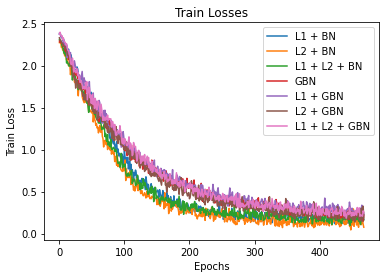

In [14]:
fig, ax = plt.subplots()
for model_number, model_version in model_versions.items():
  ax.plot(model_history[model_number]["train_loss"][0],label=model_version)
  leg = ax.legend()
  
plt.title('Train Losses')
plt.xlabel("Epochs")
plt.ylabel("Train Loss")

Text(0, 0.5, 'Validation Loss')

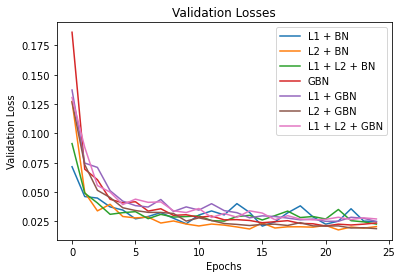

In [15]:
fig, ax = plt.subplots()
for model_number, model_version in model_versions.items():
  ax.plot(model_history[model_number]["test_loss"],label=model_version)
  leg = ax.legend()
  
plt.title('Validation Losses')
plt.xlabel("Epochs")
plt.ylabel("Validation Loss")

Text(0, 0.5, 'Train Accuracy')

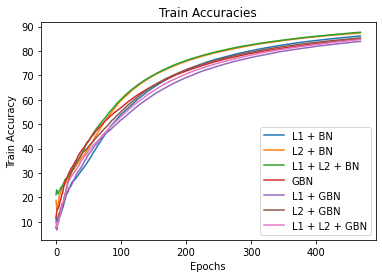

In [16]:
fig, ax = plt.subplots()
for model_number, model_version in model_versions.items():
  ax.plot(model_history[model_number]["train_acc"][0],label=model_version)
  leg = ax.legend()
  
plt.title('Train Accuracies')
plt.xlabel("Epochs")
plt.ylabel("Train Accuracy")

Text(0, 0.5, 'Validation Accuracy')

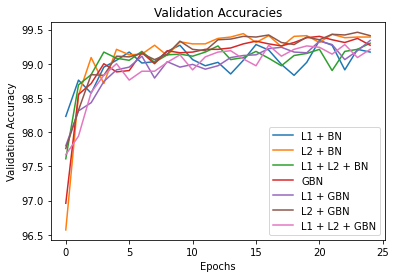

In [17]:
fig, ax = plt.subplots()
for model_number, model_version in model_versions.items():
  ax.plot(model_history[model_number]["test_acc"],label=model_version)
  leg = ax.legend()
  
plt.title('Validation Accuracies')
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")

Text(0, 0.5, 'Validation Accuracy')

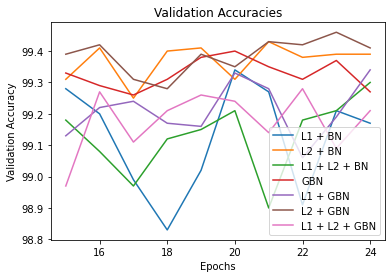

In [18]:
fig, ax = plt.subplots()
for model_number, model_version in model_versions.items():
  after15epochs_acc = model_history[model_number]["test_acc"][15:]
  ax.plot([x for x in range(15,25)],after15epochs_acc,label=model_version)
  # ax.plot(model_history[model_number]["test_acc"],label=model_version)
  leg = ax.legend()
  
plt.title('Validation Accuracies')
plt.xlabel("Epochs")
plt.ylabel("Validation Accuracy")

# plt.savefig(f'{root_path}/validation_accuracy_plot_after15epochs.png')

## Interactive Plots

In [19]:
!pip install plotly
!pip install notebook ipywidgets

In [20]:
from plotly.offline import iplot
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [21]:
# color=["white","red", "blue", "green", "yellow", "gray", "black", "orange"]
# print(color[1])
# for model_number, model_version in model_versions.items():
#   if model_number > 4:
#     after15epochs_acc = model_history[model_number]["test_acc"][15:]
#     # print(model_history[model_number]["test_acc"][15:])
#     # print([x[0] for x in after15epochs_acc])

#     fig1 = make_subplots(rows=1, cols=1)
#     fig1.add_trace(go.Scatter(x=[x for x in range(15,25)], y = [x[0] for x in after15epochs_acc]),row=1, col=1)
#     # fig1.add_trace(go.Scatter(name=model_version,x=[x for x in range(15,25)], y = [x[0] for x in after15epochs_acc],mode='markers+lines',marker=dict(color='blue', size=2),showlegend=True))
#     fig1.add_trace(go.Scatter(name=model_version,x=[x for x in range(15,25)], y = [x[0] for x in after15epochs_acc],mode='markers+lines',marker=dict(color=color[model_number], size=2),showlegend=True))
#     fig1.update_layout(height=600, width=800, title_text="Side By Side Subplots")

# fig1.show()

In [49]:
color=["white","red", "blue", "green", "yellow", "gray", "black", "orange"]
fig1 = make_subplots(rows=1, cols=1)
# fig1.add_trace(go.Scatter(x=[x for x in range(15,25)], y = [x[0] for x in model_history[1]["test_acc"][:]]),row=1, col=1)
model_number=1;fig1.add_trace(go.Scatter(name=model_versions[model_number],x=[x for x in range(15,25)], y = [x[0] for x in model_history[model_number]["test_acc"][:]],mode='markers+lines',marker=dict(color=color[model_number], size=2),showlegend=True))
model_number=2;fig1.add_trace(go.Scatter(name=model_versions[model_number],x=[x for x in range(15,25)], y = [x[0] for x in model_history[model_number]["test_acc"][:]],mode='markers+lines',marker=dict(color=color[model_number], size=2),showlegend=True))
model_number=3;fig1.add_trace(go.Scatter(name=model_versions[model_number],x=[x for x in range(15,25)], y = [x[0] for x in model_history[model_number]["test_acc"][:]],mode='markers+lines',marker=dict(color=color[model_number], size=2),showlegend=True))
model_number=4;fig1.add_trace(go.Scatter(name=model_versions[model_number],x=[x for x in range(15,25)], y = [x[0] for x in model_history[model_number]["test_acc"][:]],mode='markers+lines',marker=dict(color=color[model_number], size=2),showlegend=True))
model_number=5;fig1.add_trace(go.Scatter(name=model_versions[model_number],x=[x for x in range(15,25)], y = [x[0] for x in model_history[model_number]["test_acc"][:]],mode='markers+lines',marker=dict(color=color[model_number], size=2),showlegend=True))
model_number=6;fig1.add_trace(go.Scatter(name=model_versions[model_number],x=[x for x in range(15,25)], y = [x[0] for x in model_history[model_number]["test_acc"][:]],mode='markers+lines',marker=dict(color=color[model_number], size=2),showlegend=True))
model_number=7;fig1.add_trace(go.Scatter(name=model_versions[model_number],x=[x for x in range(15,25)], y = [x[0] for x in model_history[model_number]["test_acc"][:]],mode='markers+lines',marker=dict(color=color[model_number], size=2),showlegend=True))

fig1.update_layout(height=600, width=800, title_text="Validation Accuracies")
fig1.update_xaxes(title_text="Epochs", row=1, col=1)
fig1.update_yaxes(title_text="Validation Accuracy", row=1, col=1)
fig1.show()

# fig1.write_image("Validation Accuracies.jpeg")

In [24]:
fig1 = make_subplots(rows=1, cols=1)
model_number=1;fig1.add_trace(go.Scatter(name=model_versions[model_number],x=[x for x in range(15,25)], y = [x[0] for x in model_history[model_number]["test_acc"][15:]],mode='markers+lines',marker=dict(color=color[model_number], size=2),showlegend=True))
model_number=2;fig1.add_trace(go.Scatter(name=model_versions[model_number],x=[x for x in range(15,25)], y = [x[0] for x in model_history[model_number]["test_acc"][15:]],mode='markers+lines',marker=dict(color=color[model_number], size=2),showlegend=True))
model_number=3;fig1.add_trace(go.Scatter(name=model_versions[model_number],x=[x for x in range(15,25)], y = [x[0] for x in model_history[model_number]["test_acc"][15:]],mode='markers+lines',marker=dict(color=color[model_number], size=2),showlegend=True))
model_number=4;fig1.add_trace(go.Scatter(name=model_versions[model_number],x=[x for x in range(15,25)], y = [x[0] for x in model_history[model_number]["test_acc"][15:]],mode='markers+lines',marker=dict(color=color[model_number], size=2),showlegend=True))
model_number=5;fig1.add_trace(go.Scatter(name=model_versions[model_number],x=[x for x in range(15,25)], y = [x[0] for x in model_history[model_number]["test_acc"][15:]],mode='markers+lines',marker=dict(color=color[model_number], size=2),showlegend=True))
model_number=6;fig1.add_trace(go.Scatter(name=model_versions[model_number],x=[x for x in range(15,25)], y = [x[0] for x in model_history[model_number]["test_acc"][15:]],mode='markers+lines',marker=dict(color=color[model_number], size=2),showlegend=True))
model_number=7;fig1.add_trace(go.Scatter(name=model_versions[model_number],x=[x for x in range(15,25)], y = [x[0] for x in model_history[model_number]["test_acc"][15:]],mode='markers+lines',marker=dict(color=color[model_number], size=2),showlegend=True))

fig1.update_layout(height=600, width=800, title_text="Validation Accuracies")
fig1.update_xaxes(title_text="Epochs", row=1, col=1)
fig1.update_yaxes(title_text="Validation Accuracy", row=1, col=1)
fig1.show()

# Misclassified Images by GBN

In [40]:
# miss_classification(model, device, testloader = test_loader, model_version,  num_of_images = 25)
def miss_classification(model, device, testloader,model_version, num_of_images = 25):
    model.eval()
    misclassified_cnt = 0
    fig = plt.figure(figsize=(12,12))
    # print (f"Missclassification on {model_version}")
    fig.suptitle(f"Missclassification on {model_version}", fontsize=16)
    for data, target in testloader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        pred = output.argmax(dim=1, keepdim=True)
        pred_marker = pred.eq(target.view_as(pred))   
        wrong_idx = (pred_marker == False).nonzero()
        for idx in wrong_idx:
            index = idx[0].item()
            title = "Actual:{}, Prediction:{}".format(target[index].item(), pred[index][0].item())
            ax = fig.add_subplot(5, 5, misclassified_cnt+1, xticks=[], yticks=[]) 
            ax.set_title(title)
            plt.imshow(data[index].cpu().numpy().squeeze(), cmap='gray_r')
            misclassified_cnt += 1
            if(misclassified_cnt==num_of_images):
                break
        if(misclassified_cnt==num_of_images):
            break
    
    fig.savefig(f"({model_version})_missclassified_images.jpg") 

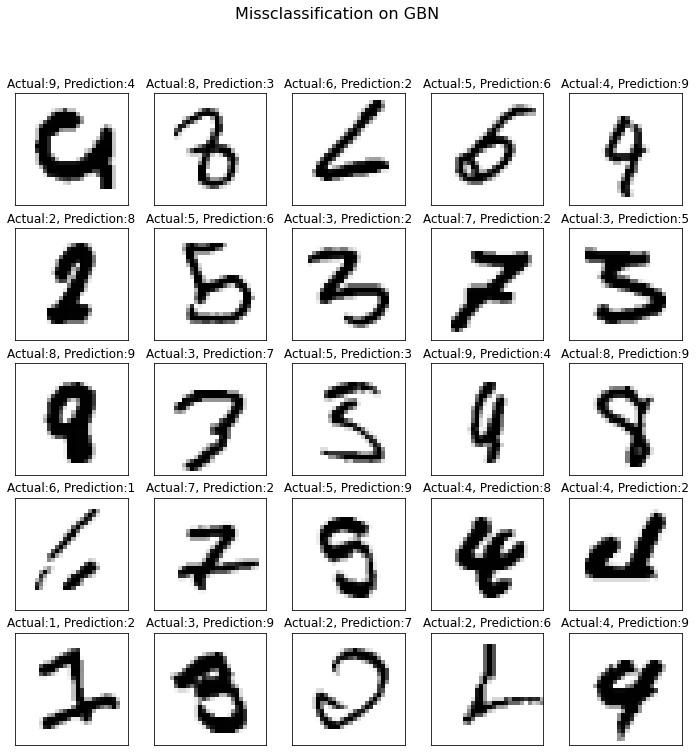

In [42]:
%matplotlib inline
miss_classification(model, device, test_loader,"GBN", num_of_images = 25)

In [46]:
# To plot for each model and create a zip

# %matplotlib inline
# for model_number, model_version in model_versions.items():
#   miss_classification(model, device, test_loader,model_version, num_of_images = 25)

# !zip img.zip *.jpg